# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
historical_positions.iloc[-1]

OMUSDT         452.713780
MKRUSDT          0.000046
UMAUSDT          0.038808
SOLUSDT          1.785416
RNDRUSDT         4.245345
BNBUSDT         -0.118000
PEPEUSDT         0.240000
ETHUSDT          0.055720
FETUSDT         11.406843
TNSRUSDT        18.365145
NEARUSDT         0.048380
NOTUSDT          2.000000
LPTUSDT          1.609294
BTCUSDT          0.005233
JASMYUSDT    12539.286069
BBUSDT         116.412195
ENSUSDT          1.348701
USDTUSDT        26.088272
XRPUSDT          0.846388
TRXUSDT        485.974547
Name: 2024-09-26 00:00:00, dtype: float64

In [11]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [12]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [13]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [14]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.round(4).sort_values(by='Total PnL')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.9350,1981.9964,1.0000,-131.8862,-202.9386,-334.8248
JASMYUSDT,387.4585,218.2469,0.1101,0.0000,-169.2116,-169.2116
ETHUSDT,250.7473,169.2341,0.0854,0.0000,-81.5133,-81.5133
BBUSDT,60.1761,31.7922,0.0160,-39.7331,-28.3839,-68.1170
PEPEUSDT,0.0000,0.0000,0.0000,-38.5220,-0.0000,-38.5220
BNBUSDT,1.1421,0.9830,0.0005,-10.6060,-0.1591,-10.7652
NEARUSDT,0.0000,0.0000,0.0000,-10.3396,0.0000,-10.3396
TRXUSDT,76.8690,79.1183,0.0399,-10.7239,2.2493,-8.4745
BTCUSDT,601.0216,589.6124,0.2975,3.5371,-11.4092,-7.8722
XRPUSDT,0.0000,0.0000,0.0000,-6.1145,0.0000,-6.1145


In [15]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [16]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [17]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [18]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [19]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [20]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [21]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities=quantities.sort_index()
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]

In [22]:
quantities_tickers=list(quantities.columns)
price_quantity=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [23]:
price_quantity.index=pd.to_datetime(price_quantity.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_quantity[col]-book_cost.iloc[-1][col])
    

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

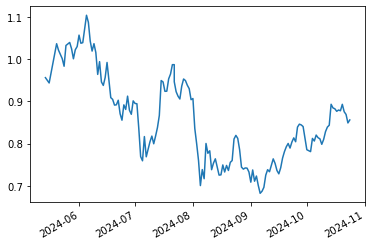

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APEUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'ORDIUSDT',
       'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [34]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9526
TRXUSDT,0.0158
OMUSDT,0.0156
BNBUSDT,0.0126
PEPEUSDT,0.0029
RAYUSDT,0.0004
PENDLEUSDT,0.0001
BTCUSDT,0.0000
STXUSDT,0.0000
WBTCUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.431353
BTCUSDT,0.300000
BNBUSDT,0.146117
TRXUSDT,0.075484
PEPEUSDT,0.047046


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.776494
OMUSDT,0.223506


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,599.538018,0.302492,0.223506,0.078986
BTCUSDT,589.612411,0.297484,0.000000,0.000000
SOLUSDT,293.471529,0.148069,0.000000,0.000000
JASMYUSDT,218.246905,0.110115,0.000000,0.000000
ETHUSDT,169.234083,0.085386,0.000000,0.000000
TRXUSDT,79.118301,0.039919,0.776494,-0.736576
BBUSDT,31.792171,0.016040,0.000000,0.000000
BNBUSDT,0.983006,0.000496,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,599.538018,0.302492,0.431353,-0.128861
BTCUSDT,589.612411,0.297484,0.300000,-0.002516
SOLUSDT,293.471529,0.148069,0.000000,0.000000
JASMYUSDT,218.246905,0.110115,0.000000,0.000000
ETHUSDT,169.234083,0.085386,0.000000,0.000000
TRXUSDT,79.118301,0.039919,0.075484,-0.035566
BBUSDT,31.792171,0.016040,0.000000,0.000000
BNBUSDT,0.983006,0.000496,0.146117,-0.145621
PEPEUSDT,0.000002,0.000000,0.047046,-0.047046


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

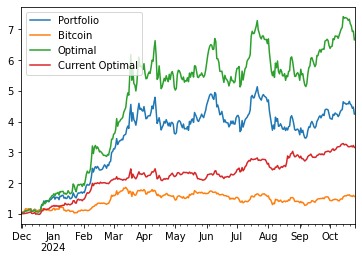

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

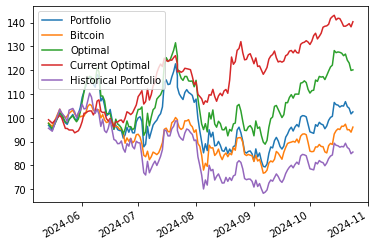

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-15,105.532247,94.576178,127.385240,141.148653,88.449327
2024-10-16,105.339658,95.342752,127.688737,141.859377,88.248334
2024-10-17,104.523048,95.062842,127.522604,141.704721,87.649254
2024-10-18,105.058278,96.471102,127.161236,140.255061,87.955984
2024-10-19,104.932961,96.400585,126.111743,138.519857,87.777630
2024-10-20,106.801861,97.318211,126.796822,138.501279,89.301219
2024-10-21,104.702404,94.957380,124.225860,138.955926,87.548545
2024-10-22,103.995220,95.025708,123.023949,139.587153,86.910207
2024-10-23,101.630975,93.952309,119.904180,138.250089,84.897981
2024-10-24,102.485534,96.083572,120.158200,140.377861,85.606483


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.637037
dtype: float64

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.510903
dtype: float64

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.581102
Bitcoin            0.431753
Optimal            0.637976
Current Optimal    0.378101
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.23164003091502083

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.173370,0.146117,0.030473,0.052489,0.011980,0.040509
BTCUSDT,0.169011,0.300000,0.044735,0.127465,0.041220,0.086246
OMUSDT,9.010447,0.431353,0.900572,0.767409,0.669585,0.097824
PEPEUSDT,0.094468,0.047046,0.013498,0.042117,0.008657,0.033461
TRXUSDT,0.036930,0.075484,0.010722,0.010520,0.001188,0.009332


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.108329,0.223506,0.252906,0.401113,0.343926,0.057187
TRXUSDT,0.203759,0.776494,0.747094,0.598887,0.541700,0.057187


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.143964,0.297030,0.406607,0.380112,0.215496,0.164617
BTCUSDT,0.001640,0.297030,0.275380,0.197164,0.053459,0.143704
SOLUSDT,-0.004395,0.148515,0.132882,0.154284,0.035087,0.119196
JASMYUSDT,-0.032314,0.108911,0.070625,0.155945,0.039361,0.116584
ETHUSDT,-0.021674,0.089109,0.062176,0.072375,0.008363,0.064013
TRXUSDT,0.010392,0.039604,0.046098,0.006012,0.000500,0.005512
BBUSDT,-0.013043,0.019802,0.006232,0.034108,0.002705,0.031403


# Value At Risk

## Historical

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05238899869990117, -0.07699204752895436)

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05048305478279984, -0.06543385845617448)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.008009
BTCUSDT     -0.016619
SOLUSDT     -0.010100
JASMYUSDT   -0.005241
ETHUSDT     -0.007746
TRXUSDT     -0.000917
BBUSDT      -0.002198
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050829
Name: 2024-08-27 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.022457
BTCUSDT     -0.012903
SOLUSDT     -0.011413
JASMYUSDT   -0.010776
ETHUSDT     -0.005121
TRXUSDT     -0.000747
BBUSDT      -0.002016
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.065434
dtype: float64

## Parametric

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.0661045582951308, -0.08472776683622336)

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05293776654886288, -0.0678515802338076)

## Multivariate

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06006101576916406, -0.07595438722115867)

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.050828088959951646, -0.0643908546750008)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.018876
BTCUSDT     -0.011029
SOLUSDT     -0.008692
JASMYUSDT   -0.007311
ETHUSDT     -0.004174
TRXUSDT     -0.000218
BBUSDT      -0.001628
Portfolio   -0.051928
dtype: float64

## Copulas

### Gaussian Copula

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05869228772752455, -0.07482061742395442)

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05186863093766207, -0.06460031826033537)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.018846
BTCUSDT     -0.010297
SOLUSDT     -0.008113
JASMYUSDT   -0.008501
ETHUSDT     -0.003960
TRXUSDT     -0.000296
BBUSDT      -0.001688
Portfolio   -0.051700
dtype: float64

### Student Copula

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.059008057891920915, -0.07587320048610734)

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054558532865261335, -0.06855595474068557)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.019821
BTCUSDT     -0.010185
SOLUSDT     -0.008238
JASMYUSDT   -0.008503
ETHUSDT     -0.004081
TRXUSDT     -0.000243
BBUSDT      -0.001811
Portfolio   -0.052883
dtype: float64

### Gumbel Copula

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11454412465040859, -0.1647551995731954)

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06733097278436798, -0.09070964870752825)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039902
BTCUSDT     -0.008449
SOLUSDT     -0.005288
JASMYUSDT   -0.009981
ETHUSDT     -0.001893
TRXUSDT     -0.000070
BBUSDT      -0.000278
Portfolio   -0.065862
dtype: float64

### Monte Carlo

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06792749787543392, -0.08372582605856445)

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05389093326019166, -0.0670569589998648)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.019572
BTCUSDT     -0.010852
SOLUSDT     -0.008306
JASMYUSDT   -0.008110
ETHUSDT     -0.004281
TRXUSDT     -0.000392
BBUSDT      -0.002258
Portfolio   -0.053771
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.055131,-0.097865,-0.080543,-0.022634
2024-01-15,-0.055131,-0.097860,-0.081671,0.018146
2024-01-16,-0.055131,-0.098068,-0.079912,0.051818
2024-01-17,-0.055131,-0.100333,-0.084823,-0.032816
2024-01-18,-0.055131,-0.101951,-0.086265,-0.026195
...,...,...,...,...
2024-10-22,-0.023706,-0.039262,-0.034917,-0.009675
2024-10-23,-0.025286,-0.040912,-0.037284,-0.025359
2024-10-24,-0.025286,-0.040897,-0.037028,0.002119
2024-10-25,-0.037031,-0.045120,-0.043174,-0.041799


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031170,-0.084286,-0.077818,-0.016580
2024-05-29,-0.027840,-0.081471,-0.072805,-0.009936
2024-05-30,-0.027840,-0.069857,-0.065177,0.030774
2024-05-31,-0.027840,-0.068904,-0.062042,0.025403
2024-06-01,-0.027840,-0.069923,-0.059811,0.040431
...,...,...,...,...
2024-10-22,-0.019282,-0.044687,-0.039905,-0.006754
2024-10-23,-0.022303,-0.047461,-0.043225,-0.022734
2024-10-24,-0.022303,-0.045692,-0.039921,0.008408
2024-10-25,-0.047526,-0.056540,-0.055877,-0.051562


<AxesSubplot:>

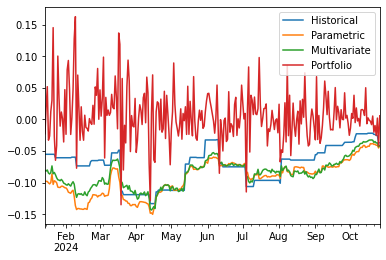

In [79]:
var_data.plot()

<AxesSubplot:>

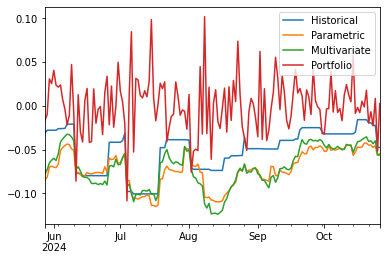

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02439,0.010453,0.010453
Kupiec Stat,4.846625,13.775234,13.775234
P-value,0.0277,0.000206,0.000206


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.078947,0.019737,0.019737
Kupiec Stat,2.297657,3.76779,3.76779
P-value,0.129569,0.052249,0.052249


## Principal Component Analysis

### Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79201338, 0.06724163, 0.05401872, 0.04509947, 0.0416268 ])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014230
ADAUSDT     0.014418
ALGOUSDT    0.015901
APEUSDT     0.017835
APTUSDT     0.015241
              ...   
WBTCUSDT    0.009919
WLDUSDT     0.022047
XECUSDT     0.015347
XLMUSDT     0.009506
XRPUSDT     0.009218
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

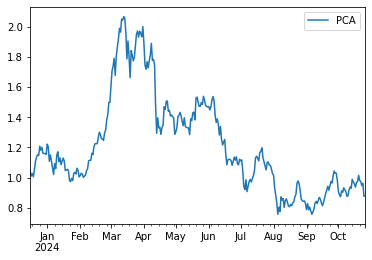

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

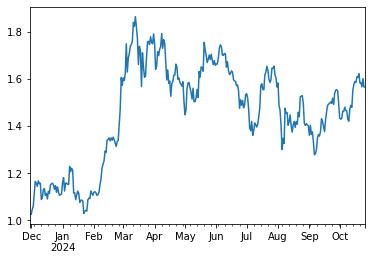

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.346823
ALGOUSDT     0.353366
ETHUSDT      0.361351
WBETHUSDT    0.361557
               ...   
BONKUSDT     0.978771
PEPEUSDT     1.013189
FLOKIUSDT    1.019736
WLDUSDT      1.072257
OMUSDT       1.324603
Length: 65, dtype: float64

<AxesSubplot:>

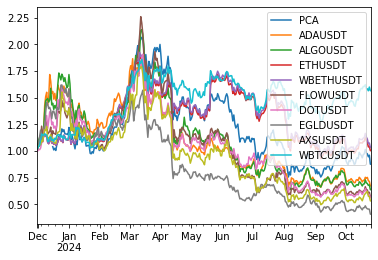

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

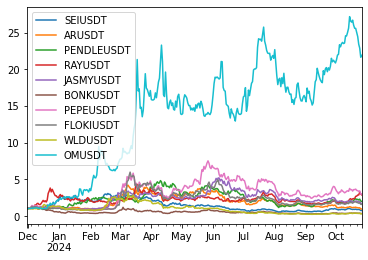

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.6796603 , 0.1347289 , 0.08644908, 0.0671808 , 0.03198092])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095059
BTCUSDT      0.064704
SOLUSDT      0.105386
JASMYUSDT    0.155937
ETHUSDT      0.087309
TRXUSDT      0.014067
BBUSDT       0.239469
BNBUSDT      0.067565
PEPEUSDT     0.170505
Name: PC1, dtype: float64

<AxesSubplot:>

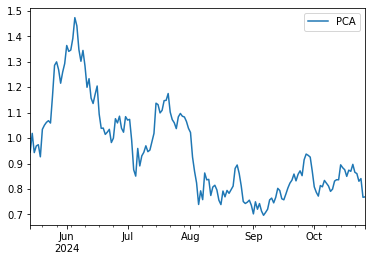

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

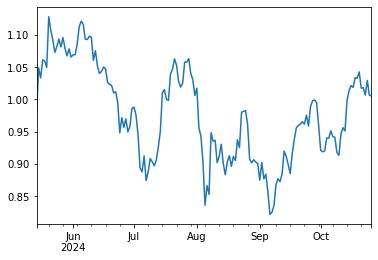

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.342035
SOLUSDT      0.353724
BTCUSDT      0.381535
BNBUSDT      0.384935
JASMYUSDT    0.430650
PEPEUSDT     0.485673
OMUSDT       0.566857
TRXUSDT      0.576353
BBUSDT       0.640718
dtype: float64

<AxesSubplot:>

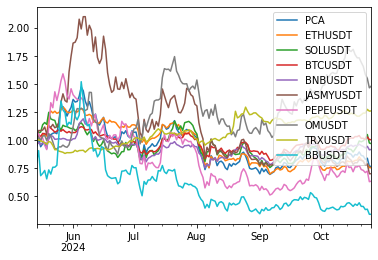

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.958007
BBUSDT       1.637491
JASMYUSDT    1.305295
SOLUSDT      1.171762
BTCUSDT      1.000000
OMUSDT       0.964321
ETHUSDT      0.960972
BNBUSDT      0.678487
TRXUSDT      0.271372
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     2.518661
BBUSDT       2.180227
JASMYUSDT    1.816036
ETHUSDT      1.246871
SOLUSDT      1.227158
BTCUSDT      1.000000
OMUSDT       0.955572
BNBUSDT      0.770243
TRXUSDT     -0.015113
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
